In [1]:
import pandas as pd
transactions = []
with open("../Data/extractedAndcleanedData/usersessions.csv", "r", encoding="utf8") as f:
    for line in f:
        parts = line.strip().split(",")
        parts = [p for p in parts if p != ""]
        transactions.append(parts)
transactions = [list(set(t)) for t in transactions]
noise = ["/images", "/icons", "/htbin"]

transactions_cleaned = [
    [item for item in t if item not in noise]
    for t in transactions
]

print("Number of transactions:", len(transactions_cleaned))
df=pd.DataFrame(transactions_cleaned)
print(df)


Number of transactions: 201965
                                     0                         1         2   \
0                       /history/apollo                  /history      None   
1                           /facilities        /shuttle/countdown      None   
2              /shuttle/missions/sts-73                      None      None   
3              /shuttle/countdown/video                      None      None   
4       /shuttle/missions/sts-71/images        /shuttle/countdown      None   
...                                 ...                       ...       ...   
201960                             None                      None      None   
201961                       /elv/SCOUT        /elv/ATLAS_CENTAUR      /elv   
201962                  /history/apollo    /history/apollo/images  /history   
201963      /shuttle/resources/orbiters  /shuttle/missions/sts-73      None   
201964                  /history/apollo                      None      None   

                3   

In [2]:
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd

te = TransactionEncoder()
te_ary = te.fit(transactions_cleaned).transform(transactions_cleaned)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)


In [3]:
from mlxtend.frequent_patterns import apriori
import pandas as pd
from itertools import combinations
from collections import defaultdict

# Manual Eclat implementation since mlxtend doesn't have it built-in
def eclat(df_encoded, min_support=0.005):
    """
    Eclat algorithm for frequent itemset mining
    """
    n_transactions = len(df_encoded)
    min_support_count = min_support * n_transactions
    
    # Get initial vertical data format (item -> transaction IDs)
    vertical_data = {}
    for col in df_encoded.columns:
        tidset = set(df_encoded[df_encoded[col] == True].index)
        if len(tidset) >= min_support_count:
            vertical_data[frozenset([col])] = tidset
    
    # Recursive function to find frequent itemsets
    def eclat_recursive(prefix, items, min_support_count):
        results = []
        
        while items:
            item, tidset = items.pop(0)
            support = len(tidset)
            
            if support >= min_support_count:
                results.append((item, support))
                
                # Generate new candidates by combining with remaining items
                suffix = []
                for other_item, other_tidset in items:
                    new_itemset = item.union(other_item)
                    new_tidset = tidset.intersection(other_tidset)
                    
                    if len(new_tidset) >= min_support_count:
                        suffix.append((new_itemset, new_tidset))
                
                # Recursively mine suffix
                if suffix:
                    results.extend(eclat_recursive(prefix, suffix, min_support_count))
        
        return results
    
    # Start mining
    items_list = list(vertical_data.items())
    frequent = eclat_recursive(frozenset(), items_list, min_support_count)
    
    # Convert to DataFrame format similar to mlxtend output
    itemsets = []
    supports = []
    
    for itemset, support in frequent:
        itemsets.append(itemset)
        supports.append(support / n_transactions)
    
    result_df = pd.DataFrame({
        'support': supports,
        'itemsets': itemsets
    })
    
    return result_df.sort_values('support', ascending=False).reset_index(drop=True)

# Run Eclat
frequent_itemsets = eclat(df_encoded, min_support=0.005)
print("Frequent Itemsets using Eclat:")
print(frequent_itemsets)

# Generate association rules
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, 
                          metric="confidence", 
                          min_threshold=0.5)

print("\nAssociation Rules:")
print(rules)

Frequent Itemsets using Eclat:
      support                                           itemsets
0    0.254311                               (/shuttle/countdown)
1    0.206293                           (/history/apollo/images)
2    0.117109                                (/shuttle/missions)
3    0.101582                         (/shuttle/missions/sts-71)
4    0.094407                         (/shuttle/missions/sts-70)
..        ...                                                ...
318  0.005115  (/history/apollo/apollo-13, /history/apollo/ap...
319  0.005090  (/shuttle/resources/orbiters, /shuttle/countdo...
320  0.005090      (/shuttle/missions, /shuttle/missions/sts-72)
321  0.005055               (/shuttle/missions/sts-70, /history)
322  0.005040  (/shuttle/missions/sts-71/movies, /shuttle/mis...

[323 rows x 2 columns]

Association Rules:
                                           antecedents  \
0                           (/shuttle/countdown/video)   
1                            

In [4]:
frequent_itemsets.to_csv("../Data/ECLAT/ECLAT_frequent_itemsets.csv", index=False)
rules.to_csv("../Data/ECLAT/ECLAT_rules.csv", index=False)


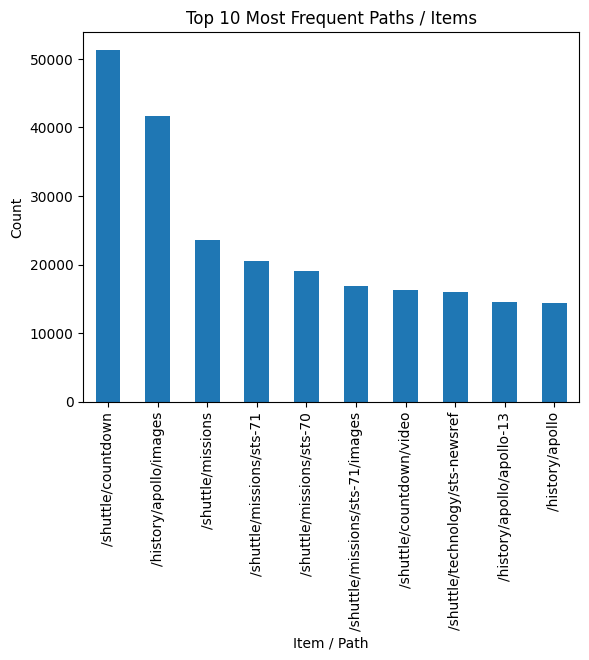

In [5]:
import matplotlib.pyplot as plt

all_items = df.values.flatten()  

all_items = [str(x) for x in all_items if str(x).strip() not in ["", "NA","None"]]

items_series = pd.Series(all_items)

top_items = items_series.value_counts().head(10)

top_items.plot(kind='bar', title='Top 10 Most Frequent Paths / Items')
plt.xlabel("Item / Path")
plt.ylabel("Count")
plt.show()

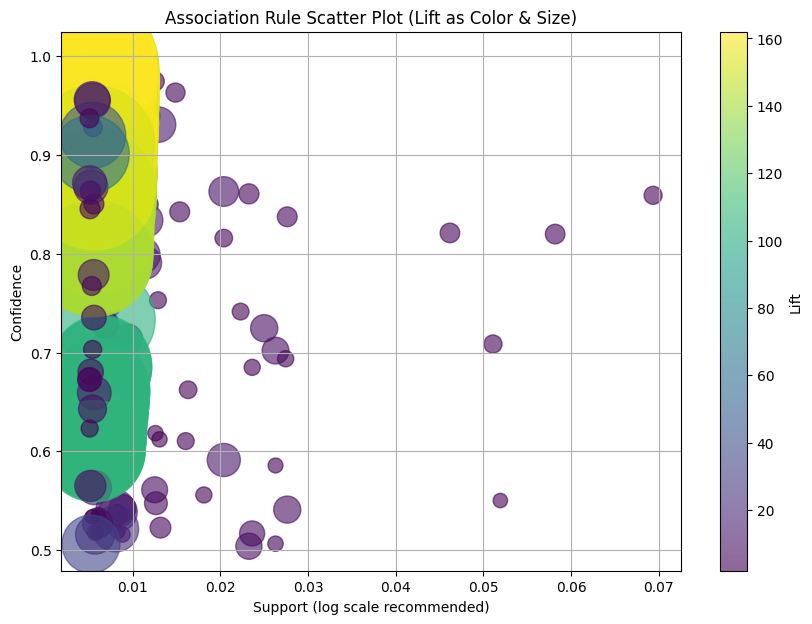

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

plt.scatter(
    rules['support'],
    rules['confidence'],
    s=rules['lift'] * 50,  
    c=rules['lift'],
    cmap='viridis',
    alpha=0.6
)

plt.colorbar(label="Lift")
plt.xlabel("Support (log scale recommended)")
plt.ylabel("Confidence")
plt.title("Association Rule Scatter Plot (Lift as Color & Size)")
plt.grid(True)
plt.show()
